# A/B Testing Outcomes of E-commerce Company

## Introduction
An e-commerce company aims to boost its conversion rate for product purchases by implementing a new UI change. With an annual conversion rate currently at about 13%, the company hopes this change will achieve at least a 2% improvement. In this notebook, we will evaluate the outcomes of such A/B testing.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load data

There are two datasets. Let us call the first one "df_ab", which includes A/B testing results.    
The second one contains user geographic information, i.e., "df_country

### 1.1 A/B Testing

In [2]:
df_ab = pd.read_csv("/home/ychen/Downloads/ab_data.csv")

In [3]:
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- user_id: User ID.
- timestamp: Timestamp of the user's visit to the page.
- group: Two groups are defined; 'treatment', which refers to users who should see the new UI, and 'control', which pertains to users seeing the old design.
- landing_page: Specifies whether the user landed on the new or old page.
- converted: Indicates whether a conversion was successful (1) or not (0), such as purchasing a product.

In [5]:
df_ab["group"].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

The two groups have slightly different numbers of users. 

In [6]:
df_ab["landing_page"].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

However, the landing page groups are equally split.
These data are supposed to correspond to the respective groups.
We will process and clean the data in the next section.


### 1.2 Users Geographic

In [7]:
df_country = pd.read_csv("/home/ychen/Downloads/countries_ab.csv")

In [8]:
df_country.head()

,id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [9]:
df_country["country"].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Users come from three countries in this A/B Testing, or, this E-commerce commpany actually runs only for these three areas (which might be impossible).

---
## 2. Process and Clean

Before moving onto cleaning part, let us combine these two dataframes first.

In [10]:
df = df_ab.merge(df_country, how='left', left_on='user_id', right_on='id')[['user_id','timestamp','group',
                                                                            'landing_page','converted','country']]
df.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


Now let us check if there are values with NaN.

### 2.1 NaN

In [11]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
country         0
dtype: int64

As aforementioned, there are 294478 entries in "df_ab", while "df_country" only have 290584 entries.     
These two datasets are inconsistent. Let us take a look in detail.

In [12]:
print("How many unique id in df_ab? ", df_ab['user_id'].nunique())
print("How many unique id in df_ctounry? ", df_country['id'].nunique())

How many unique id in df_ab?  290584
How many unique id in df_ctounry?  290584


There must be some duplicated ids.

### 2.2 Duplicated values

In [13]:
df.duplicated().sum()

0

In [14]:
df['user_id'].duplicated().sum()

3894

3894 users have seen both the new and old pages, or other situations...

Let us take a further look.

In [15]:
df[df['user_id'].duplicated()]['user_id']

2656      698120
2893      773192
7500      899953
8036      790934
10218     633793
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 3894, dtype: int64

In [16]:
df[df['user_id'] == 698120]

,user_id,timestamp,group,landing_page,converted,country
988,698120,2017-01-22 07:09:37.540970,control,new_page,0,US
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0,US


The user 698120 has seen both the new and old pages.

In [17]:
df[df['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted,country
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,US
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,US


In [18]:
df[df['user_id'] == 899953]

,user_id,timestamp,group,landing_page,converted,country
3489,899953,2017-01-05 05:36:02.120641,treatment,new_page,0,CA
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0,CA


Both of users 773192 and 899953 have visited the new page twice.

Since we have enough data, we can now delete these entries.

In [19]:
del_id = df[df['user_id'].duplicated()]['user_id'].values
df['user_id'].isin(del_id).sum()

7788

In [20]:
df = df[~df['user_id'].isin(del_id)]
print("How many entries after removing? ", len(df))
df.head()

How many entries after removing?  286690


,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


### 2.3 Timestamp

First, let us reformat timestamp from string to datetime.    
Then add a few parameters, such as weekday, am/pm.

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [22]:
df['weekday'] = df['timestamp'].apply(lambda x: x.weekday())
df['weekday_name'] = df['timestamp'].apply(lambda x: x.strftime('%A'))
df['am_pm'] = df['timestamp'].apply(lambda x: x.strftime('%p'))
df.head()

,user_id,timestamp,group,landing_page,converted,country,weekday,weekday_name,am_pm
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US,5,Saturday,PM
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US,3,Thursday,AM
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US,2,Wednesday,PM
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US,6,Sunday,PM
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US,5,Saturday,AM


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
 5   country       286690 non-null  object        
 6   weekday       286690 non-null  int64         
 7   weekday_name  286690 non-null  object        
 8   am_pm         286690 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 21.9+ MB


In [24]:
print("How long this test has been implemented? \n{} days".format(len(df['timestamp'].dt.day.unique())))

How long this test has been implemented? 
23 days


### 2.4 Final Check
Make sure the control group accesses the old page, and the experimental group visits the new page.

In [25]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


So far, we can confirm that all users in the control group visited the old page, while those in the treatment group visited the new page.

---
## 3. Visualize data

### 3.1 Parameters versus Country

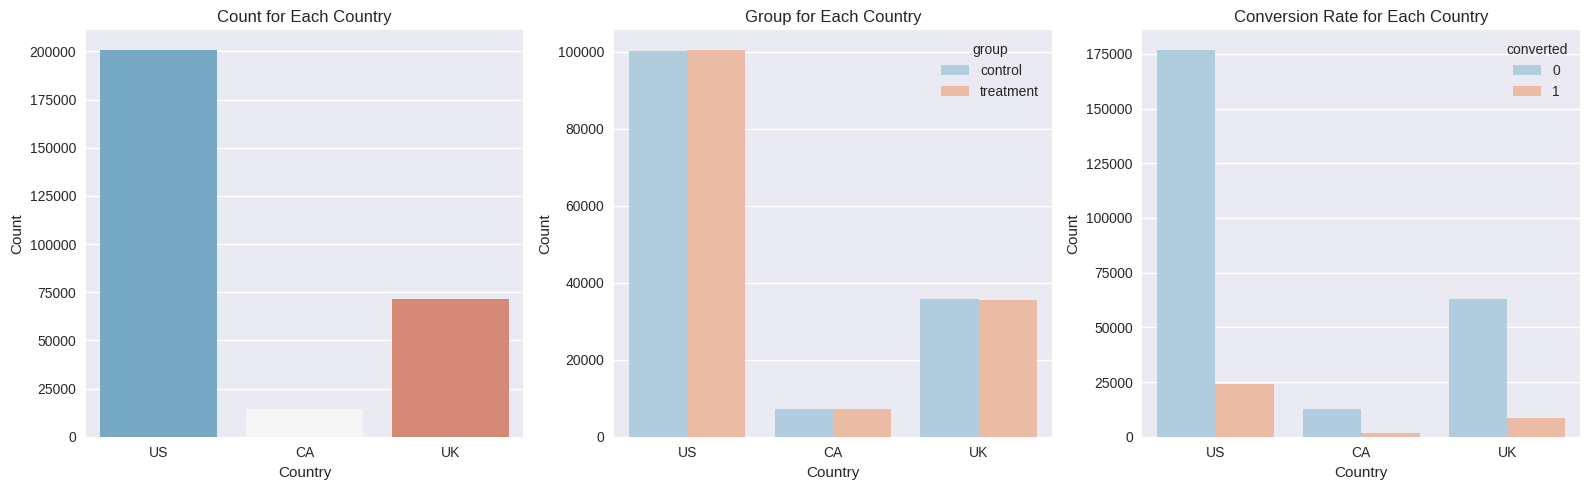

In [26]:
plt.style.use('seaborn')
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
sns.countplot(x='country', data=df, hue='country', ax=ax[0], palette='RdBu_r')
ax[0].set_title('Count for Each Country')
ax[0].set_xlabel('Country')
ax[0].set_ylabel('Count')

sns.countplot(x='country', data=df, hue='group', ax=ax[1], palette='RdBu_r')
ax[1].set_title('Group for Each Country')
ax[1].set_xlabel('Country')
ax[1].set_ylabel('Count')

sns.countplot(x='country', data=df, hue='converted', ax=ax[2], palette='RdBu_r')
ax[2].set_title('Conversion Rate for Each Country')
ax[2].set_xlabel('Country')
ax[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

It is unclear whether the UK or the US has a slightly higher conversion rate. Let's explore this from another perspective.

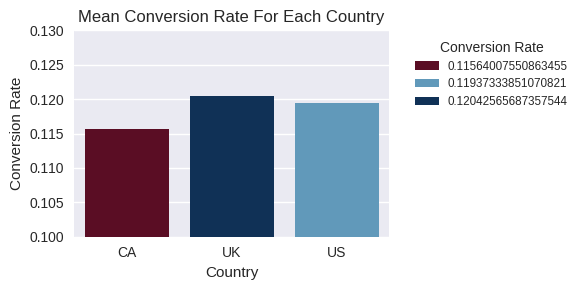

In [27]:
df_rate_country = df.groupby('country').mean()
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.barplot(x='country', y='converted', data=df_rate_country, hue='converted', palette='RdBu')
ax.set_title('Mean Conversion Rate For Each Country')
ax.legend(title="Conversion Rate", fontsize='small', bbox_to_anchor=(1.05, 1))
ax.set_xlabel('Country')
ax.set_ylabel('Conversion Rate')
ax.set_ylim([0.1,0.13])
plt.tight_layout()
plt.show()

The answer is UK!

### 3.2 Parameters versus Time

In [28]:
df_weekday = df.groupby(['country', 'weekday_name'],as_index=False)['converted'].mean()
df_weekday.head()

,country,weekday_name,converted
0,CA,Friday,0.117617
1,CA,Monday,0.129412
2,CA,Saturday,0.111226
3,CA,Sunday,0.121150
4,CA,Thursday,0.119494


In [29]:
df_ampm = df.groupby(['country', 'am_pm'],as_index=False)['converted'].mean()
df_ampm.head()

,country,am_pm,converted
0,CA,AM,0.113636
1,CA,PM,0.117706
2,UK,AM,0.119249
3,UK,PM,0.121609
4,US,AM,0.118332


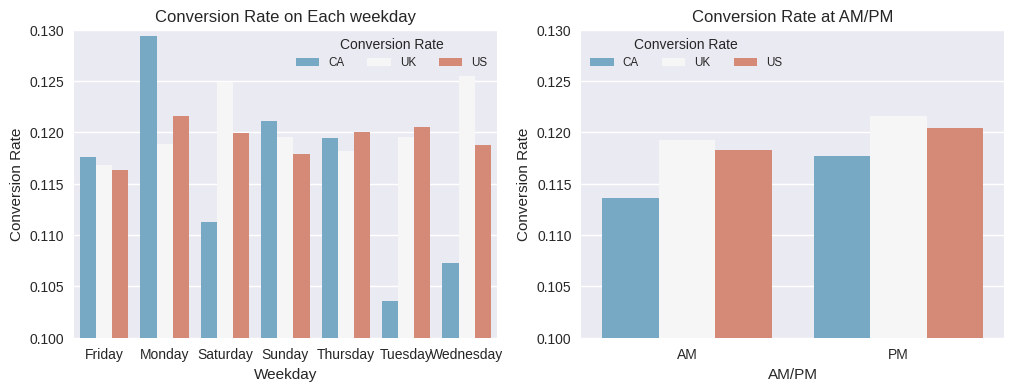

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(x='weekday_name', y='converted', data=df_weekday, hue='country', ax=ax[0], palette='RdBu_r')
ax[0].set_title('Conversion Rate on Each weekday')
ax[0].set_xlabel('Weekday')
ax[0].set_ylabel('Conversion Rate')
ax[0].set_ylim([0.1,0.13])
ax[0].legend(title="Conversion Rate", ncol=3, fontsize='small', bbox_to_anchor=(0.5, 1.01))

sns.barplot(x='am_pm', y='converted', data=df_ampm, hue='country', ax=ax[1], palette='RdBu_r')
ax[1].set_title('Conversion Rate at AM/PM')
ax[1].set_xlabel('AM/PM')
ax[1].set_ylabel('Conversion Rate')
ax[1].set_ylim([0.1,0.13])
ax[1].legend(title="Conversion Rate", ncol=3, fontsize='small', bbox_to_anchor=(0.5, 1.01))

plt.show()

In [31]:
df_weekday_all = df.groupby(['weekday_name'],as_index=False)['converted'].mean()
df_weekday_all

,weekday_name,converted
0,Friday,0.116563
1,Monday,0.121298
2,Saturday,0.120710
3,Sunday,0.118488
4,Thursday,0.119562
5,Tuesday,0.119450
6,Wednesday,0.119814


It's quite surprising that users in CA have the highest conversion rate on Mondays! Regarding the AM/PM distinction, this poses a tricky question, as it's challenging to determine whether users browsing at 00:30 should be counted as AM or PM.

---
## 4. Assess the outcome

### 4.1 Hypothesis test

Theoretically, we should choose a one-tailed test since the company aims to improve by 2%. However, since we do not know whether the UI change will perform better or worse than the old page, this assessment requires a two-tailed test.

For this two tailed test:
- Null hypothesis $H_0: P = P_0$
- Alternative hypothesis: $H_\alpha = P \neq P_0$
* $P_0$ and $P$ represent the conversion rates for the old and new pages respectively.



### 4.2 Sample size

Let us determine the sample size:
$$N = \frac{\sigma^2}{\delta^2}(Z_{1-\frac{\alpha}{2}}+Z_{1-\beta})^2$$ 
- $ \sigma^2 = P_A(1-P_A) + P_B(1-P_B) $
- Critial value $\alpha$: $\alpha = 0.05$, setting a 95% confidence level that the new page has a better conversion rate before we can reject the null hypothesis
- Power of the test $1-\beta$: $\beta$ = 0.2, indicating an 80% chance of detecting a statistically significant difference if the new page genuinely has a better conversion rate.

In [32]:
import scipy.stats as stats
import statsmodels.stats.api as sms

# PA = 0.13, PB = 0.15
effect_size = sms.proportion_effectsize(0.13, 0.15)
required_n = sms.NormalIndPower().solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
print("How many samples we need for each group? ", np.ceil(required_n))

How many samples we need for each group?  4720.0


Let us use 5000 as sample size.

In [33]:
required_n = 5000
def sample_group_conversion(required_n, df):
    control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
    treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)
    # combine two groups into one dataframe
    ab_test = pd.concat([control_sample, treatment_sample], axis=0)
    ab_test.reset_index(drop=True, inplace=True)
    # check each group again
    check_ab_test = pd.crosstab(ab_test['group'], ab_test['landing_page'])
    # calculate the mean conversion rate
    conversion_rate = ab_test.groupby('group')['converted'].agg([np.mean, np.std])
    conversion_rate.columns = ['conversion_rate', 'std_deviation']
    
    return ab_test, check_ab_test, conversion_rate

In [34]:
ab_test, check_ab_test, conversion_rate = sample_group_conversion(required_n, df)
check_ab_test

landing_page,new_page,old_page
group,,
control,0,5000
treatment,5000,0


In [35]:
conversion_rate

,conversion_rate,std_deviation
group,,
control,0.1232,0.328700
treatment,0.1266,0.332558


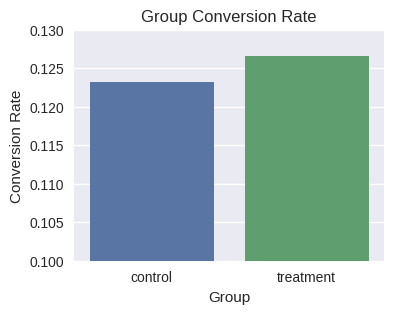

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
sns.barplot(x='group', y='converted', data=ab_test, hue = 'group',errorbar=('ci', False))
plt.ylim(0.1, 0.13)
plt.title('Group Conversion Rate')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.show()

The treatment group that visited the new page has a 0.3% higher conversion rate than the control group. However, is this difference statistically significant?

### 4.3 Z-test

Since we have a large sample size, we choose the Z-test.

In [37]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def hypotheses_test(ab_test):
    control_results = ab_test[ab_test['group'] == 'control']['converted']
    treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
    # counts in control group
    n_con = control_results.count()
    # counts in treatment group
    n_treat = treatment_results.count()
    # since successful is 1, use sum to calculate payments
    successes = [control_results.sum(), treatment_results.sum()]
    # nobs are total counts in each group
    nobs = [n_con, n_treat]
    # perform z-test
    z_stat, pval = proportions_ztest(successes, nobs = nobs)
    # two ends of confidence interval for control and treatment groups
    (lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs = nobs, alpha=0.05)
    
    return z_stat, pval, lower_con, upper_con, lower_treat, upper_treat

In [38]:
z_stat_all, pval_all, lower_con_all, upper_con_all, lower_treat_all, upper_treat_all = hypotheses_test(ab_test)

print(f'z_stat: {z_stat_all:.2f}')
print(f'p-value: {pval_all:.2f}')
print(f'CI 95% for control: [{lower_con_all:.3f}, {upper_con_all:.3f}]')
print(f'CI 95% for treatment: [{lower_treat_all:.3f}, {upper_treat_all:.3f}]')

z_stat: -0.51
p-value: 0.61
CI 95% for control: [0.114, 0.132]
CI 95% for treatment: [0.117, 0.136]


Oops...    
p-value=0.61, which is higher than $\alpha$, i.e., 0.05    
CI 95% for treatment includes 13%

### 4.3 Hypothesis test for Different Countries

First, we need to ensure that each country has an enough sample size to perform the hypothesis test.

In [39]:
print("How many data points we have for users in each country and group?")
df_3country = df.groupby(['country','group'], as_index=False)['user_id'].nunique()
df_3country

How many data points we have for users in each country and group?


,country,group,user_id
0,CA,control,7094
1,CA,treatment,7209
2,UK,control,35883
3,UK,treatment,35630
4,US,control,100316
5,US,treatment,100558


The aforementioned effect size is 4720, indicating that we can apply the same test across all three countries.

In [40]:
df_ca = df[df['country']=='CA']
df_uk = df[df['country']=='UK']
df_us = df[df['country']=='US']

ab_test_ca, check_ab_test_ca, conversion_rate_ca = sample_group_conversion(required_n, df_ca)
ab_test_uk, check_ab_test_uk, conversion_rate_uk = sample_group_conversion(required_n, df_uk)
ab_test_us, check_ab_test_us, conversion_rate_us = sample_group_conversion(required_n, df_us)

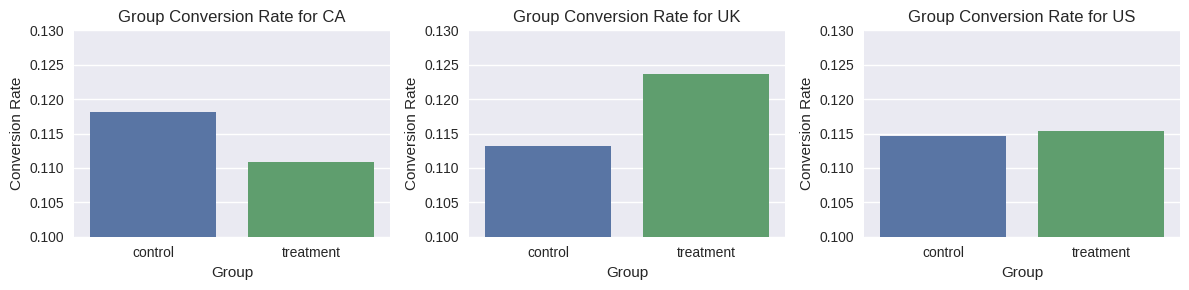

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.barplot(x='group', y='converted', data=ab_test_ca, hue = 'group',errorbar=('ci', False), ax=ax[0])
ax[0].set_ylim([0.1, 0.13])
ax[0].set_title('Group Conversion Rate for CA')
ax[0].set_xlabel('Group')
ax[0].set_ylabel('Conversion Rate')

sns.barplot(x='group', y='converted', data=ab_test_uk, hue = 'group',errorbar=('ci', False), ax=ax[1])
ax[1].set_ylim([0.1, 0.13])
ax[1].set_title('Group Conversion Rate for UK')
ax[1].set_xlabel('Group')
ax[1].set_ylabel('Conversion Rate')

sns.barplot(x='group', y='converted', data=ab_test_us, hue = 'group',errorbar=('ci', False), ax=ax[2])
ax[2].set_ylim([0.1, 0.13])
ax[2].set_title('Group Conversion Rate for US')
ax[2].set_xlabel('Group')
ax[2].set_ylabel('Conversion Rate')

plt.tight_layout()
plt.show()

It looks like UK users may have a postive result!

In [42]:
z_stat_ca, pval_ca, lower_con_ca, upper_con_ca, lower_treat_ca, upper_treat_ca = hypotheses_test(ab_test_ca)
print('Hypotheis test for CA users:')
print(f'z_stat: {z_stat_ca:.2f}')
print(f'p-value: {pval_ca:.2f}')
print(f'CI 95% for control: [{lower_con_ca:.3f}, {upper_con_ca:.3f}]')
print(f'CI 95% for treatment: [{lower_treat_ca:.3f}, {upper_treat_ca:.3f}]')

z_stat_uk, pval_uk, lower_con_uk, upper_con_uk, lower_treat_uk, upper_treat_uk = hypotheses_test(ab_test_uk)

print('\nHypotheis test for UK users:')
print(f'z_stat: {z_stat_uk:.2f}')
print(f'p-value: {pval_uk:.2f}')
print(f'CI 95% for control: [{lower_con_uk:.3f}, {upper_con_uk:.3f}]')
print(f'CI 95% for treatment: [{lower_treat_uk:.3f}, {upper_treat_uk:.3f}]')

z_stat_us, pval_us, lower_con_us, upper_con_us, lower_treat_us, upper_treat_us = hypotheses_test(ab_test_us)

print('\nHypotheis test for US users:')
print(f'z_stat: {z_stat_us:.2f}')
print(f'p-value: {pval_us:.2f}')
print(f'CI 95% for control: [{lower_con_us:.3f}, {upper_con_us:.3f}]')
print(f'CI 95% for treatment: [{lower_treat_us:.3f}, {upper_treat_us:.3f}]')

Hypotheis test for CA users:
z_stat: 1.16
p-value: 0.25
CI 95% for control: [0.109, 0.127]
CI 95% for treatment: [0.102, 0.120]

Hypotheis test for UK users:
z_stat: -1.61
p-value: 0.11
CI 95% for control: [0.104, 0.122]
CI 95% for treatment: [0.114, 0.133]

Hypotheis test for US users:
z_stat: -0.13
p-value: 0.90
CI 95% for control: [0.106, 0.123]
CI 95% for treatment: [0.107, 0.124]


It seems worse in CA now.

---
## Summary

Note that we can accept the alternative hypothesis only when the p-value is less than the critical value. However, this result indicates that the p-value of 0.61 exceeds the significance level ($\alpha$=0.05), leading us to **fail to reject** the null hypothesis $H_0$. This suggests that the new UI design does not significantly differ from the old one nor does it perform better. Additionally, the confidence interval for the treatment group includes the original average conversion rate of 13% but does not reach our target of 15%. Consequently, the new page is effectively similar to the old one and fails to improve the conversion rate.

When analyzed by country, the treatment group appears to have a slightly higher conversion rate for UK users, nearly no change for US users, and a decrease for CA users. However, all p-values exceed α, indicating no statistical significance that the new page improves conversions to product payments. Therefore, this e-commerce company should consider either redesigning their webpage or maintaining the current one.